<a href="https://colab.research.google.com/github/yannick5000/Fake-News-Detector-Covid-19-Vaccine/blob/main/Kopie_von_tensor_flow_Fake_news_LSTM_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

In [ ]:
pip install tensorflow --upgrade

In [ ]:
import sys  
print(sys.executable) # show the pathway where python is stored

In [ ]:
!pip install wordcloud

In [5]:
# first neuronal network: RNN Applications , text classification,translation...
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import matplotlib as plt
import nltk
from nltk.corpus import stopwords
#from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt


In [7]:
tf.__version__

'2.10.0'

In [8]:
# dismiss warning message
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


# Start




In [ ]:
# real world example: text classification
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Fake News Tracker/statements.csv", index_col="Index")
df["Statement"]=df["Statement"].str.replace("[^\w\s]","")

In [ ]:
df.shape

(965, 7)

In [ ]:
df.rename(columns={"True/False" : 'trueORfalse'}, inplace=True)
df.head()


,Statement,Source,Source (URL),Date + time,trueORfalse,Evidence (why true?),Category
Index,,,,,,,
1,Bei den Jugendlichen und jungen Erwachsenen se...,ÄrzteZeitung,https://www.aerztezeitung.de/Medizin/STIKO-emp...,2022-05-24 13-45,True,"Reliable Publisher, specialized newspaper","child vaccination, complications"
2,Im Frühjahr 2021 hatten Berichte über sehr sel...,ÄrzteZeitung,https://www.aerztezeitung.de/Medizin/Einsatz-d...,2022-05-06 14-11,True,"Reliable Publisher, specialized newspaper",complications
3,Immunologe Radbruch betonte dass geimpfte Gene...,ÄrzteZeitung,https://www.aerztezeitung.de/Panorama/Ueber-25...,2022-05-04 12-48,True,"Reliable Publisher, specialized newspaper",efficacy of vaccination
4,Der COVID19Impfstoff Spikevax von Moderna ist ...,ÄrzteZeitung,https://www.aerztezeitung.de/Medizin/Spikevax-...,2022-03-04 16-42,True,"Reliable Publisher, specialized newspaper","child vaccination, age limit"
5,Zum zweiten empfiehlt die STIKO den Impfstoff ...,ÄrzteZeitung,https://www.aerztezeitung.de/Medizin/STIKO-Fue...,2022-02-03 13-34,True,"Reliable Publisher, specialized newspaper",age limit


In [ ]:
print((df.trueORfalse==1).sum()) # True 502
print((df.trueORfalse==0).sum()) # False  463

502
463


In [ ]:
# preprocessing
df["Statement"]=df["Statement"].str.replace("[^\w\s]","")
df_dro=pd.get_dummies(df.iloc[:,0])
frames=[ df_dro,df["trueORfalse"]]  
df_final=pd.concat(frames, axis=1)       
df_final 
df_final.tail()  
a=df["trueORfalse"].eq(1).groupby(df["Statement"]).mean().reset_index()
a

,Statement,trueORfalse
0,An COVID würden fast nur diejenigen Menschen ...,0.0
1,Azithromycin kann das CovidVirus abtöten,0.0
2,Bleichmittel zu trinken um das Virus im Körpe...,0.0
3,Chloroquin kann das CovidVirus abtöten,0.0
4,Die COVID19 Impfung schützt nicht nur die gei...,1.0
...,...,...
952,mRNAImpfstoffe können unser Erbgut verändern,0.0
953,mRNAImpfstoffe verändern die DNA im Körper der...,0.0
954,okalreaktionen Schmerzen an der Einstichstelle...,1.0
955,Ähnlich wie bei Erwachsenen ist der Schutz vor...,1.0


In [ ]:
a["Statement"] = a["Statement"].apply(lambda x: str(x) )
a["Statement"] = a["Statement"].apply(lambda x: x.lower() ) # lower case
a["Statement"]= a["Statement"].apply(lambda x: x.strip()) # Remove whitespace left and right
a

,Statement,trueORfalse
0,an covid würden fast nur diejenigen menschen s...,0.0
1,azithromycin kann das covidvirus abtöten,0.0
2,bleichmittel zu trinken um das virus im körper...,0.0
3,chloroquin kann das covidvirus abtöten,0.0
4,die covid19 impfung schützt nicht nur die geim...,1.0
...,...,...
952,mrnaimpfstoffe können unser erbgut verändern,0.0
953,mrnaimpfstoffe verändern die dna im körper der...,0.0
954,okalreaktionen schmerzen an der einstichstelle...,1.0
955,ähnlich wie bei erwachsenen ist der schutz vor...,1.0


In [ ]:
# for this section see  : just couple of lines
#https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

In [ ]:
#Tokenize — Create Vocab to Int mapping dictionary
from collections import Counter
all_text2 = ' '.join(a["Statement"])  # will reunite every sentences as a text
# create a list of words
words = all_text2.split()  # splot the text into words
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)
print (count_words)

Counter({'die': 596, 'der': 565, 'und': 348, 'in': 277, 'von': 243, 'eine': 228, 'mit': 219, 'nach': 185, 'das': 161, 'ist': 159, 'bei': 152, 'werden': 142, 'zu': 141, 'impfung': 141, 'für': 133, 'einer': 124, 'dass': 123, 'den': 115, 'sind': 112, 'als': 110, 'ein': 106, 'nicht': 101, 'covid19': 101, 'im': 99, 'des': 93, 'vor': 92, 'es': 91, 'personen': 89, 'auch': 88, 'gegen': 88, 'oder': 83, 'auf': 79, 'dem': 70, 'durch': 68, 'können': 64, 'menschen': 63, 'ab': 63, 'kann': 62, 'impfstoff': 62, 'einem': 61, 'wird': 59, 'sich': 58, 'jahren': 58, 'einen': 57, 'an': 56, 'zur': 53, 'hat': 52, 'auffrischimpfung': 49, 'infektion': 47, 'aus': 47, 'sie': 43, 'haben': 43, 'stiko': 43, 'wie': 42, 'grundimmunisierung': 41, 'impfstoffe': 41, 'geimpfte': 40, 'keine': 40, 'impfstoffdosis': 38, 'impfungen': 38, 'mehr': 36, 'virus': 36, 'geimpften': 36, 'geimpft': 36, 'nur': 35, 'sarscov2': 34, 'covid19impfung': 33, 'wurden': 33, 'comirnaty': 33, 'risiko': 32, 'daten': 32, 'bis': 32, 'schutz': 31, 'w

In [ ]:
#In order to create a vocab to int mapping dictionary, you would simply do this
vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}
len(vocab_to_int)
#vocab_to_int    #{'impfung': 0, and so on..

3550

In [ ]:
#6)Tokenize — Encode the words
Statement_int = []
for review in a["Statement"]:
    r = [vocab_to_int[w] for w in review.split()]
    Statement_int.append(r)
print (Statement_int[0:3])
#Statement_int

[[44, 229, 176, 398, 64, 1401, 35, 188, 0, 1402, 21, 60, 350, 12, 594, 399], [595, 37, 8, 845, 264], [1403, 12, 478, 81, 8, 61, 23, 148, 1404]]


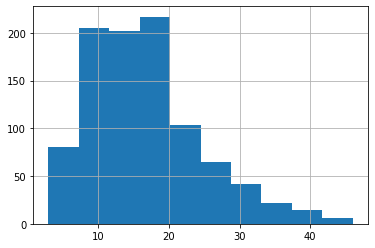

count    957.000000
mean      16.670846
std        7.940635
min        3.000000
25%       11.000000
50%       15.000000
75%       21.000000
max       46.000000
dtype: float64

In [ ]:
#Analyze Reviews Length
%matplotlib inline
Statement_len = [len(x) for x in Statement_int]
pd.Series(Statement_len).hist()
plt.show()
pd.Series(Statement_len).describe()  

In [ ]:
#Mean review length = 9
#b) no reviews are of length 0 .
#c) Most of the reviews less than 15 words or more 
#d) There are quite a few reviews that are extremely long, max lenght 30

In [ ]:
# Tokenization : bring sentences into world
nltk.download("punkt")
nltk.download("wordnet")
a["Statement"]= a["Statement"].apply(lambda x: nltk.word_tokenize(x))
a

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Statement,trueORfalse
0,"[an, covid, würden, fast, nur, diejenigen, men...",0.0
1,"[azithromycin, kann, das, covidvirus, abtöten]",0.0
2,"[bleichmittel, zu, trinken, um, das, virus, im...",0.0
3,"[chloroquin, kann, das, covidvirus, abtöten]",0.0
4,"[die, covid19, impfung, schützt, nicht, nur, d...",1.0
...,...,...
952,"[mrnaimpfstoffe, können, unser, erbgut, veränd...",0.0
953,"[mrnaimpfstoffe, verändern, die, dna, im, körp...",0.0
954,"[okalreaktionen, schmerzen, an, der, einstichs...",1.0
955,"[ähnlich, wie, bei, erwachsenen, ist, der, sch...",1.0


In [ ]:
# import the stop word
            # german stop word fron nltk
nltk.download("stopwords")

stopWordsGerman = stopwords.words("german")
len(stopWordsGerman)  #232 words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


232

In [ ]:
# Remove Stop word in our Statements 
a["Statement"]= a["Statement"].apply(lambda element: [word for word in element if not word in stopWordsGerman])
a

,Statement,trueORfalse
0,"[covid, fast, diejenigen, menschen, sterben, o...",0.0
1,"[azithromycin, covidvirus, abtöten]",0.0
2,"[bleichmittel, trinken, virus, körper, abzutöten]",0.0
3,"[chloroquin, covidvirus, abtöten]",0.0
4,"[covid19, impfung, schützt, geimpfte, person, ...",1.0
...,...,...
952,"[mrnaimpfstoffe, erbgut, verändern]",0.0
953,"[mrnaimpfstoffe, verändern, dna, körper, geimp...",0.0
954,"[okalreaktionen, schmerzen, einstichstelle, rö...",1.0
955,"[ähnlich, erwachsenen, schutz, omikronvariante...",1.0


In [ ]:
#You can join the list of above words to create a sentence without stop words, as shown below:
a["Statement"] = a["Statement"].apply(lambda x: ' '.join([word for word in x]))
a

,Statement,trueORfalse
0,covid fast diejenigen menschen sterben ohnehin...,0.0
1,azithromycin covidvirus abtöten,0.0
2,bleichmittel trinken virus körper abzutöten,0.0
3,chloroquin covidvirus abtöten,0.0
4,covid19 impfung schützt geimpfte person reduzi...,1.0
...,...,...
952,mrnaimpfstoffe erbgut verändern,0.0
953,mrnaimpfstoffe verändern dna körper geimpften ...,0.0
954,okalreaktionen schmerzen einstichstelle rötung...,1.0
955,ähnlich erwachsenen schutz omikronvariante ver...,1.0


            # example of Lemmatization
#python -m spacy download de_core_news_sm     #to download the German language module

import spacy
text = "Ich heisse Arnelle und ich kommes aus Kamerun. Kannst du dorthin kommen?"
doc = nlp(text)
words_lemmas_list = [token.lemma_ for token in doc]
print(words_lemmas_list)
text = ' '.join([token.lemma_ for token in doc])
print(text)

In [ ]:
        # Lemmatization  real document
    
#python -m spacy download de_core_news_sm     #to download the German language module
!python -m spacy download de_core_news_sm
import spacy
nlp = spacy.load("de_core_news_sm")
#text=open('statements.csv').read()              #statements.csv muss auf Colab gespeichert sein
for i in range(len(a["Statement"])):
    a["Statement"][i]= nlp(a["Statement"][i])
    a["Statement"][i] = [token.lemma_ for token in a["Statement"][i]]
    #a["Statement"][i] = ' '.join([token.lemma_ for token in a["Statement"][i]])
a["Statement"] = a["Statement"].apply(lambda x: ' '.join([word for word in x]))
a["Statement"] = a["Statement"].apply(lambda x: x.lower())

                # Model ist not working properly with the letimization!!! see 309 line

In [ ]:
for element in a["Statement"]:
    print(element)

covid fast derjenige mensch sterben ohnehin mehr lange leben haben
azithromycin covidvirus abtöten
bleichmittel trinken virus körper abzutöen
chloroquin covidvirus abtöten
covid19 impfung schützen geimpft person reduzieren risiko geimpft person person anstecken
einnahme vitamin d verhindern mildern erkrankung
geben hinweis darauf frau durchgemacht coronainfektion unfruchtbar sein
ffp2 masken befinden metallfäd roboter
ffp2 masken befinden parasit morgellon
abstrichstäbch schnelltest befinden metallfäd roboter
abstrichstäbch schnelltest befinden parasit morgellon
ivermectin südafrika mittel covid19 zulassen
ivermectin covid erkrankung heilen
alkohol können viren körper abtöten
virus einatmen heiß luft nase abtöten
23 mensch laut bericht norwegisch arzneimittelbehörde sterben nachdem impfstoff biontec pfizer bekommen
50 angestellter berliner sanaklinikum covid19impfung sterben
60000 wissenschaftlerinn ärtzinn fordern great barrington declaration globale impfstopp
ab 1august frankreich ei

In [ ]:
# prepare the text and use it for a RNN
# 1) count all the different words
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:  #for each lines
        for word in text.split():  #we split the lines and iterate
            count[word] +=1    # each time the word appears, we count it +1
    return count
counter = counter_word(a.Statement)

In [ ]:
len(counter)  #2981
#print(counter)

3039

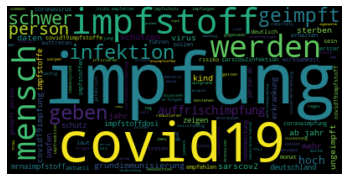

In [ ]:
from collections import Counter
import wordcloud
common_words=''
for i in a.Statement:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<class 'collections.Counter'>


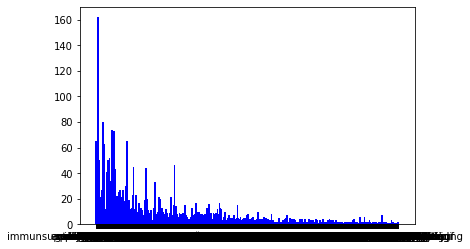

In [ ]:
import collections
#from matplotlib import pyplot as plt
print(type(counter))
#plt.hist(counter, bins=4)
#plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(counter.keys(), counter.values(), color = 'b', width = 18)
plt.show()
#help(plt)

In [ ]:
counter.most_common(5)

[('impfung', 162),
 ('person', 102),
 ('covid19', 101),
 ('impfstoff', 80),
 ('jahr', 74)]

In [ ]:
num_unique_words= len(counter)

#How to split a dataset to train, test, and validation
#sets with SK Learn?

In [ ]:
#Import the libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
a


,Statement,trueORfalse
0,covid fast derjenige mensch sterben ohnehin me...,0.0
1,azithromycin covidvirus abtöten,0.0
2,bleichmittel trinken virus körper abzutöen,0.0
3,chloroquin covidvirus abtöten,0.0
4,covid19 impfung schützen geimpft person reduzi...,1.0
...,...,...
952,mrnaimpfstoffen erbgut verändern,0.0
953,mrnaimpfstoffen verändern dna körper geimpft p...,0.0
954,okalreaktion schmerz einstichstell rötung schw...,1.0
955,ähnlich erwachsen schutz omikronvariant vergle...,1.0


In [ ]:
train = a.iloc[:,0].values # Statements
test = a.iloc[:,1].values # True and Valse randomised as 0 and 1



In [ ]:
# split dataset into training and validation set
#train_size = int(a.shape[0]*0.8)  #765
#train_a = a[:train_size]
#val_a = a[train_size:]


# here code from  https://www.malicksarr.com/split-train-test-validation-python/
#How to split a dataset to train, test, and validation sets with SK Learn?
#https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

In [ ]:
# set aside 20% of train and test data for evaluation
#X_train, X_test, y_train, y_test = train_test_split(train, test,
   # test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
  #  test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [ ]:
# set aside 80% of train and test data for evaluation
X_train, X_rest, y_train, y_rest = train_test_split(train, test,
    train_size=0.8, shuffle = True, random_state = 8)  #0.8

# Use the same function above for the validation set
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest,  #0.5
    test_size=0.5, random_state= 8) # 0.5 x 0.2 = 0.1

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("y_val shape: {}".format(y_val.shape))


X_train shape: (765,)
X_test shape: (96,)
X_val shape: (96,)
y_train shape: (765,)
y_test shape: (96,)
y_val shape: (96,)


In [ ]:
# split text and  labels
train_sentences = X_train   #the model learn your data.Set of data used for learning (by the model), that is, to fit the parameters to the machine learning model
train_labels = y_train
val_sentences = X_val       # the model provide an unbiased evaluation of a model fitted on the training dataset while tuning model hyperparameters.
val_labels = y_val
test_sentences = X_test     # unbiased evaluation of a final model fitted on the training dataset.
test_label = y_test
#test_label



In [ ]:
train_sentences.shape, val_sentences.shape,test_sentences.shape 
#((765,), (96,), (96,))

((765,), (96,), (96,))

In [ ]:
# Tokenize

from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers

tokenizer = Tokenizer(num_words= num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [ ]:
# each word has unique index
word_index = tokenizer.word_index
word_index

{'impfung': 1,
 'person': 2,
 'covid19': 3,
 'impfstoff': 4,
 'jahr': 5,
 'geimpft': 6,
 'werden': 7,
 'schwer': 8,
 'ab': 9,
 'mensch': 10,
 'infektion': 11,
 'auffrischimpfung': 12,
 'empfehlen': 13,
 'geben': 14,
 'kind': 15,
 'zeigen': 16,
 'stiko': 17,
 'hoch': 18,
 'grundimmunisierung': 19,
 'ungeimpft': 20,
 'covid19impfung': 21,
 'virus': 22,
 'impfen': 23,
 'sterben': 24,
 'daten': 25,
 'risiko': 26,
 'erkrankung': 27,
 'sarscov2': 28,
 'mehr': 29,
 'schutz': 30,
 'comirnaty': 31,
 'wirksamkeit': 32,
 'monat': 33,
 'schützen': 34,
 'impfstoffe': 35,
 'deutschland': 36,
 '2': 37,
 'moderna': 38,
 'studie': 39,
 'erhalten': 40,
 'covid19impfstoffe': 41,
 'mrnaimpfstoff': 42,
 'coronaimpfung': 43,
 'laut': 44,
 'gegenüber': 45,
 'woche': 46,
 '30': 47,
 'impfstoffdosis': 48,
 'spikevax': 49,
 'gut': 50,
 'deutlich': 51,
 'treten': 52,
 'sein': 53,
 'auftreten': 54,
 'impfstoffen': 55,
 'aktuell': 56,
 'kurz': 57,
 'nuvaxovid': 58,
 'führen': 59,
 '12': 60,
 'häufig': 61,
 'körper

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [ ]:
print(train_sentences[10:15]) # normal text
print(train_sequences[10:15])  # sentences with word index

['justin bieber gesichtslähmung nebenwirkung covid19impfung'
 'bisherig studie treten schwer unerwünscht nebenwirkung stillenden der kindern impfung'
 'mrna impfstoffe basieren dna verändern'
 'zwiebeln knoblauch wirken virus töten ab'
 'lang nachbeobachtungszeit 15 30 minute sollen vorsichtshalber bestimmt risikoperson eingehalt beispiel person gerinnungshemmung impfkomplikation anamnese']
[[1009, 1010, 312, 69, 21], [211, 39, 52, 8, 173, 69, 1011, 64, 116, 1], [99, 35, 559, 212, 149], [1012, 560, 213, 22, 209, 9], [117, 401, 150, 47, 253, 70, 1013, 561, 1014, 1015, 132, 2, 1016, 562, 563]]


In [ ]:
# sequences can have different lenght. we need them to have the same lenght

from tensorflow.keras.preprocessing.sequence import pad_sequences

# max number of words in a sequence
max_lenght = 40  # or 20 ? why?
train_padded = pad_sequences(train_sequences, maxlen=max_lenght, padding = "post", truncating = "post")
val_padded = pad_sequences(val_sequences, maxlen= max_lenght, padding ="post", truncating = "post")
#NEU
test_padded = pad_sequences(test_sequences, maxlen= max_lenght, padding ="post", truncating = "post")
train_padded.shape, val_padded.shape , test_padded.shape



((765, 40), (96, 40), (96, 40))

In [ ]:
train_padded[10]

array([1009, 1010,  312,   69,   21,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

justin bieber gesichtslähmung nebenwirkung covid19impfung
[1009, 1010, 312, 69, 21]
[1009 1010  312   69   21    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# check if everything is correct by reversing it
# for example 1: model and instaed of model:1

# flip(key,value)
reverse_word_index = dict([(idx,word) for (word,idx) in word_index.items()])
reverse_word_index

{1: 'impfung',
 2: 'person',
 3: 'covid19',
 4: 'impfstoff',
 5: 'jahr',
 6: 'geimpft',
 7: 'werden',
 8: 'schwer',
 9: 'ab',
 10: 'mensch',
 11: 'infektion',
 12: 'auffrischimpfung',
 13: 'empfehlen',
 14: 'geben',
 15: 'kind',
 16: 'zeigen',
 17: 'stiko',
 18: 'hoch',
 19: 'grundimmunisierung',
 20: 'ungeimpft',
 21: 'covid19impfung',
 22: 'virus',
 23: 'impfen',
 24: 'sterben',
 25: 'daten',
 26: 'risiko',
 27: 'erkrankung',
 28: 'sarscov2',
 29: 'mehr',
 30: 'schutz',
 31: 'comirnaty',
 32: 'wirksamkeit',
 33: 'monat',
 34: 'schützen',
 35: 'impfstoffe',
 36: 'deutschland',
 37: '2',
 38: 'moderna',
 39: 'studie',
 40: 'erhalten',
 41: 'covid19impfstoffe',
 42: 'mrnaimpfstoff',
 43: 'coronaimpfung',
 44: 'laut',
 45: 'gegenüber',
 46: 'woche',
 47: '30',
 48: 'impfstoffdosis',
 49: 'spikevax',
 50: 'gut',
 51: 'deutlich',
 52: 'treten',
 53: 'sein',
 54: 'auftreten',
 55: 'impfstoffen',
 56: 'aktuell',
 57: 'kurz',
 58: 'nuvaxovid',
 59: 'führen',
 60: '12',
 61: 'häufig',
 62: 'kö

In [ ]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [ ]:
decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[1009, 1010, 312, 69, 21]
justin bieber gesichtslähmung nebenwirkung covid19impfung


In [ ]:
pip install keras-tuner --upgrade

In [ ]:
pip install bayesian-optimization

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#from bayes_opt import BayesianOptimization


from keras.models import Sequential
from keras.layers import Dense

Second YT Tutorial



In [ ]:
pip install -U keras-tuner

In [ ]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
print(keras.__version__)

2.9.0


In [ ]:
#from tensorflow.keras.metrics import AUC
#from tensorflow.keras.metrics import Accuracy

In [ ]:
def build(hp):


    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh',
                          'linear',
                          'selu',
                          'elu'
                        ])

    num_rnn_layers = hp.Int(
                        'num_rnn_layers', 
                        min_value=0,
                        max_value=12,
                        default=3)

    recurrent_dropout = hp.Float(
                        'recurrent_dropout', 
                        min_value=0.0,
                        max_value=0.99,
                        default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=0,
                        max_value=64,
                        default=32)
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(num_unique_words, 32, input_length=max_lenght))
    model.add(keras.layers.LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout)) #,input_shape=(X_train.shape[1], 1)

    #model.add(keras.layers.Dense(units=1, activation = "sigmoid"))
    model.add(keras.layers.Dense(units=1, activation = 'sigmoid'))

    #model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Accuracy()])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])
    
  



    return model

In [ ]:
bayesian_opt_tuner = keras_tuner.BayesianOptimization(
    build,
    objective=keras_tuner.Objective(name='val_accuracy', direction='max'),
    #objective=["accuracy"],
    max_trials=5,
    executions_per_trial=3, 
    overwrite=True)

n_epochs=20   

In [ ]:
bayesian_opt_tuner.search(train_padded, train_labels,epochs=n_epochs,
     validation_data=(val_padded, val_labels),
     validation_split=0.2,verbose=2)


Trial 5 Complete [00h 01m 36s]
val_accuracy: 0.59375

Best val_accuracy So Far: 0.8680555621782938
Total elapsed time: 00h 07m 36s


In [ ]:
bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

In [ ]:
model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            97248     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 122,145
Trainable params: 122,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.history

In [ ]:
predictions = model.predict(test_padded)
predictions= [1 if p>0.5 else 0 for p in predictions]

In [ ]:
test_data = 'Covid is killing people'. # 
print(model.predict(test_padded))


3/3 [==============================] - 2s 31ms/step
[[1.16008773e-01]
 [4.31799054e-01]
 [9.99999940e-01]
 [1.00000000e+00]
 [7.49035913e-04]
 [5.75957620e-06]
 [1.00000000e+00]
 [3.02164368e-02]
 [9.98969793e-01]
 [1.62915379e-01]
 [1.00000000e+00]
 [9.72889662e-01]
 [1.00000000e+00]
 [3.75026576e-02]
 [9.99984860e-01]
 [1.00000000e+00]
 [7.88631034e-04]
 [9.99999821e-01]
 [3.24131761e-05]
 [3.26561742e-02]
 [1.00000000e+00]
 [4.55029368e-01]
 [5.73144481e-03]
 [1.53418258e-01]
 [8.83631945e-01]
 [7.53671154e-02]
 [2.52505958e-01]
 [9.77843583e-01]
 [1.00000000e+00]
 [1.55230919e-02]
 [3.22671490e-12]
 [9.81778085e-01]
 [8.92169058e-01]
 [9.99999881e-01]
 [1.72116011e-01]
 [6.07138500e-02]
 [1.23047270e-02]
 [7.61028886e-01]
 [1.72498897e-01]
 [4.61639545e-04]
 [6.86826885e-01]
 [9.91609573e-01]
 [1.00000000e+00]
 [9.95542049e-01]
 [9.99855816e-01]
 [1.76932735e-06]
 [5.49109140e-03]
 [1.08672688e-02]
 [1.00000000e+00]
 [4.88026720e-03]
 [1.00000000e+00]
 [9.99566317e-01]
 [9.99899447

In [ ]:
# visualize the results
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
model.save('models/LSTM_Fakenews_Model_2.h5')

In [ ]:
from tensorflow.keras.models import load_model 

In [ ]:
#def load_prediction_model(model_file):   # Why is this code not returning a model ?
  #loaded_model = load_model(model_file)
  #return loaded_model

new_model = load_model('models/LSTM_Fakenews_Model_2.h5')

In [ ]:
load_prediction_model('models/LSTM_Fakenews_Model_2.h5')

In [ ]:
new_model.summary()

In [ ]:
new_model.get_weights()

In [ ]:
new_model.optimizer

In [ ]:
def Classifier(input_reshaped):
  prediction = new_model.predict(input_reshaped)
  predictions = [1 if p>0.5 else 0 for p in predictions]
  #print('The score of the classification is: ', prediction[0])
  if (predictions == 0):
    print('The news are FAKE !')
  else:
    print('The news are TRUE !')  

In [ ]:
#print(train_sentences[56:65])   # Model ist not working properly with the letimization!!!
print(train_labels[56:65])
print(predictions[56:65])

In [ ]:
predictions = new_model.predict(train_padded) # Zurzeit eine Denkblockade, jedoch wie schreibe Ich den code, sodass er uns eine Predicition angibt ? 
predictions= [1 if p>0.5 else 0 for p in predictions]

#Anvil Server

In [ ]:
pip install anvil-uplink

In [ ]:
import anvil.server

anvil.server.connect("XOIQTHUV2WN5USIVFXN7ZLPP-MV76TSDHRY77ASEH")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [ ]:
@anvil.server.callable
def predict_newsclass(user_input):
  prediction = model.predict(user_input)
  predictions = [1 if p>0.5 else 0 for p in predictions]
  correct = "The statement is correct"
  false = "The statement is false"
  if prediction == 0:
    preds = correct
  else:
    preds = false
  return preds  
  
  
  #print('The score of the classification is: ', prediction[0])
  #if (predictions == 0):
    #print('The news are FAKE !')
  #else:
    #print('The news are TRUE !')


In [ ]:
def classifier(user_input):
  prediction = new_model.predict(user_input)
  predictions = [1 if p>0.5 else 0 for p in predictions]
  correct = "The statement is correct"
  false = "The statement is false"
  if prediction == 0:
    preds = correct
  else:
    preds = false
  return preds  

In [ ]:
classifier('Covid is a virus')